# Chapter 7

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

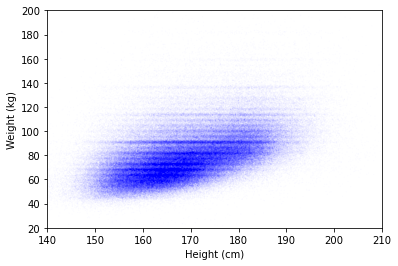

In [13]:
# Solution
# With smaller markers, I needed more aggressive jittering to
# blur the measurement artifacts

# With this dataset, using all of the rows might be more trouble
# than it's worth.  Visualizing a subset of the data might be
# more practical and more effective.

heights = Jitter(df.htm3, 2.8)
weights = Jitter(df.wtkg2, 1.0)

thinkplot.Scatter(heights, weights, alpha=0.01, s=2)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

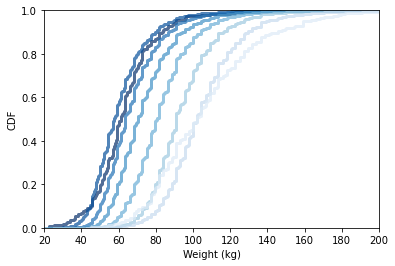

In [20]:
# Solution
bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

thinkplot.PrePlot(len(cdfs))
thinkplot.Cdfs(cdfs)
thinkplot.Config(xlabel='Weight (kg)',
                 ylabel='CDF',
                 axis=[20, 200, 0, 1],
                 legend=False)

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [21]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [22]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697767

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [23]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [24]:
Corr(heights, weights)

0.5087364789734607

NumPy provides a function that computes correlations, too:

In [25]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [26]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [27]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [28]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [29]:
SpearmanCorr(heights, weights)

0.5405846262320491

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [30]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.5317282605983443

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [31]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [32]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [34]:
# Solution
ages = live.agepreg
weights = live.totalwgt_lb
print('Corr :', Corr(ages, weights))
print('SpearmanCorr :', SpearmanCorr(ages, weights))

Corr : 0.06883397035410908
SpearmanCorr : 0.09461004109658226


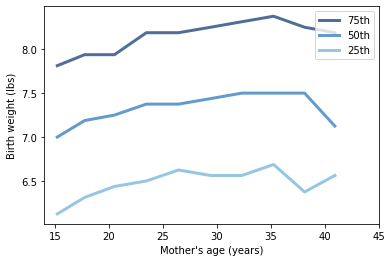

In [35]:
# Solution
def BinnedPercentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)

    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups][1:-1]

    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weights = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(ages, weights, label=label)

    thinkplot.Config(xlabel="Mother's age (years)",
                     ylabel='Birth weight (lbs)',
                     xlim=[14, 45], legend=True)
    
BinnedPercentiles(live)

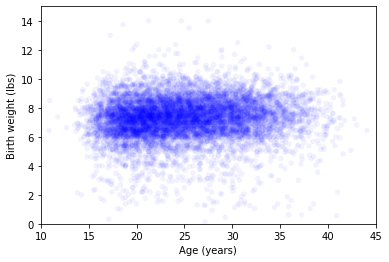

In [36]:
# Solution: scatter plot
def ScatterPlot(ages, weights, alpha=1.0, s=20):
    """Make a scatter plot and save it.

    ages: sequence of float
    weights: sequence of float
    alpha: float
    """
    thinkplot.Scatter(ages, weights, alpha=alpha)
    thinkplot.Config(xlabel='Age (years)',
                     ylabel='Birth weight (lbs)',
                     xlim=[10, 45],
                     ylim=[0, 15],
                     legend=False)
    
ScatterPlot(ages, weights, alpha=0.05, s=10)

In [37]:
# My conclusion:

# 1) The scatterplot shows a weak relationship between the variables but
#    it is very hard to see clearly with the eyes.

# 2) The correlations support this.  Pearson's is around 0.068, Spearman's
#    is around 0.094.  The difference between them suggests the influence
#    of outliers or a non-linear relationsip between the data variables.

# 3) Plotting percentiles of Weight(lbs) versus Age(Years) suggests that the
#    relationship is non-linear.  Birth weight increases more quickly
#    in the range of mother's age from 15 to 25.  After that, the effect
#    is a bit weaker.